In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Problem 7: : the Old Faithful

The data contains waiting times between eruptions and the duration of the eruptions for the Old Faithful geyser in Yellowstone National Park, Wyoming, USA

In [2]:
url = 'https://raw.githubusercontent.com/um-perez-alvaro/Data-Science-Practice/master/Data/faithful.csv'
data = pd.read_csv(url,sep = '\s+')
data

,eruptions,waiting
1,3.600,79
2,1.800,54
3,3.333,74
4,2.283,62
5,4.533,85
...,...,...
268,4.117,81
269,2.150,46
270,4.417,90
271,1.817,46


![old](https://raw.githubusercontent.com/um-perez-alvaro/Data-Science-Practice/master/Jupyter%20Notebooks/Clustering/practice%20problems/old_faithful.jpg)

In [7]:
X = data[['eruptions','waiting']].to_numpy()

Text(0.5, 0, 'duration of eruption')

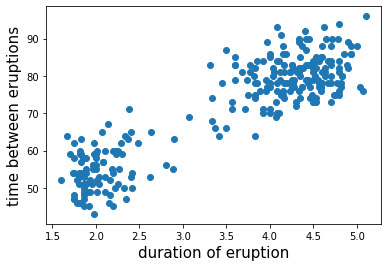

In [8]:
plt.scatter(X[:,0], X[:,1])
plt.ylabel('time between eruptions', fontsize=15)
plt.xlabel('duration of eruption', fontsize=15)

**Part 1:** Fit a Gaussian Mixture model to the data (with k=2)

In [10]:
def evaluate_multivariate_normal(X,mean,cov):
    m,n = X.shape
    return np.exp(-0.5*np.array([(X[i]-mean).dot((np.linalg.inv(cov)).dot(X[i]-mean))
                        for i in range(m)])) /  np.sqrt(np.linalg.det(cov)*(2*np.pi)**n)

In [16]:
def em(X,k,max_iter=100):
    'expectation-maximization algorithm'
    
    # size of X
    m,n = X.shape
    
    # initializations
    cov = [np.eye(n) for i in range(k)] # identity matrices
    mean = X[np.random.choice(m,k,replace=False)] 
    pi = [1/k for i in range(k)]
    
    # initialize responsibility matrix
    R = np.zeros((m,k))
    
    # EM iterations
    for i in range(max_iter):
        # EXPECTATION STEP
        for i in range(k):
            R[:,i] = evaluate_multivariate_normal(X,mean[i],cov[i])
        # multiply by cluster probabilities pi
        R = R*pi
        # normalize rows
        R = R/np.sum(R,axis=1,keepdims=True)
        
        # MAXIMIZATION STEP
        mc = np.sum(R,axis=0)
        pi = mc/m
        for i in range(k):
            # weighted mean
            mean[i] = np.average(X,axis=0,weights=R[:,i])
            # weighted covariance matrix
            cov[i] = np.cov(X,rowvar=False,aweights=R[:,i])
    return cov,mean,pi

In [18]:
k = 2
cov, mean,pi = em(X,k)

In [19]:
mean

array([[ 4.2896878 , 79.96841278],
       [ 2.03642144, 54.47887964]])

In [20]:
cov

[array([[ 0.17091213,  0.94562169],
        [ 0.94562169, 36.24895215]]),
 array([[ 0.06991678,  0.4400356 ],
        [ 0.4400356 , 34.05107916]])]

In [21]:
pi

array([0.64411455, 0.35588545])

**Part 2:** Plot the log probability distribution

In [22]:
def plot_log_probability_distribution(X,cov,mean,pi):
    """
    this function plots:
        - level curves of the proba. distribution (negative logarithm)
        - cluster means
        - cluster boundaries
    
    """
    from matplotlib.colors import LogNorm  
    resolution = 500
    
    # number of clusters
    k = len(pi)
    
    # create a mesh grid
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    points = np.c_[xx.ravel(), yy.ravel()]
    Rpoints = np.zeros((resolution**2,k))
    for i in range(k):
        Rpoints[:,i] = evaluate_multivariate_normal(points,mean[i],cov[i])
    # multiply by cluster probabilities pi
    Rpoints = Rpoints*pi
    # sum along columns
    prob = -np.log(np.sum(Rpoints,axis=1).reshape(xx.shape))
    # cluster prediction
    pred = np.argmax(Rpoints,axis=1).reshape(xx.shape)

    plt.contourf(xx, yy, prob,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                     levels=np.logspace(0, 2, 12))

    plt.contour(xx, yy, prob,linewidths=1,colors='black',
               norm=LogNorm(vmin=1.0, vmax=30.0),
                     levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, pred,
                    linewidths=2, colors='r', linestyles='dashed')
    # plot means
    for i in range(k):
        plt.scatter(mean[i][0],mean[i][1],
                    marker='o', s=20, linewidths=8,
                    color='w', zorder=10, alpha=0.9)
        plt.scatter(mean[i][0],mean[i][1],
                    marker='x', s=50, linewidths=2,
                    color='r', zorder=11, alpha=1)

    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plt.colorbar()
    plt.title('log probability distribution')

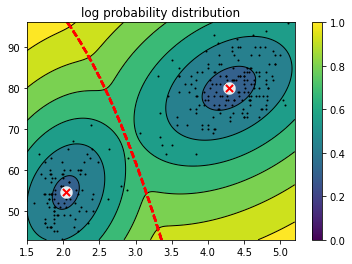

In [23]:
plot_log_probability_distribution(X,cov,mean,pi)

**Part 3:** Sample $m=300$ points from the fiited Gaussian mixture. Plot the sampled points.

In [25]:
def sample_gaussian_mixture(m,cov,mean,pi):
    k = len(mean) # number of gaussian distributions
    dist = np.random.choice(k,m,p=pi) # distributions
    X = np.zeros((m,2))
    for i in range(k):
        ni = np.sum(dist==i) # number of points from dist. i
        X[dist==i] = np.random.multivariate_normal(mean = mean[i], cov = cov[i], size=ni)
    return X

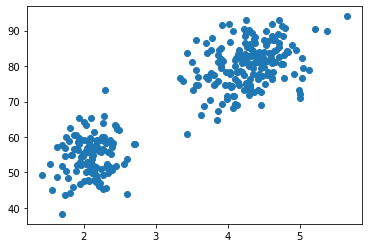

In [27]:
m = 300
newX = sample_gaussian_mixture(m,cov,mean,pi)
plt.scatter(newX[:,0],newX[:,1])